In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model_less_weird import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 20000
N_bar = 20000
num_states = 100
steps = 100
start_t = steps-25 # Start of time window

In [3]:
cache_states = [25, 75]
forget_state = 75

# Run Task (with learning)

In [4]:
num_trials = 10
num_recaches = 10


cache_acts = np.zeros([num_trials, num_recaches, num_states, N_bar])
retrieval_acts = np.zeros([num_trials, num_recaches, num_states, N_bar])
post_cache_fantasy_reconstructions = np.zeros([num_trials, num_recaches, num_states, N_inp])
post_retrieval_fantasy_reconstructions = np.zeros([num_trials, num_recaches, num_states, N_inp])
post_cache_fantasy_acts = np.zeros([num_trials, num_recaches, num_states, N_bar])
post_retrieval_fantasy_acts = np.zeros([num_trials, num_recaches, num_states, N_bar])

for trial in range(num_trials):
    
    search_factor = 1.0

    model = Model(
        N_inp, N_bar, num_states,
        steps=steps,
        divisive_normalization=20.0,
        forget_readout_lr=0.25, forget_lr=3.5, forget_plasticity_bias=-2.2
    )

    place_inputs = PlaceInputs(N_inp, num_states).get_inputs()


    model.reset()
    

    
    print("Trial", trial, "Initial caches")

    for cache_state in cache_states:
        preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
        model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])




    

    for r in range(num_recaches):
        
        print("Trial", trial, "Recache", r)

        _, recall_acts, recall_reconstruct, recall_acts_over_time = model.run_recall(search_factor, place_inputs, n_zero_input=0)

        post_cache_fantasy_reconstructions[trial, r] = recall_reconstruct
        post_cache_fantasy_acts[trial, r] = recall_acts

        
        preacts, acts, reconstruction, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)

        model.reverse_update(acts[forget_state])

        retrieval_acts[trial, r] = acts_over_time[steps-1][forget_state].copy()

        _, recall_acts, recall_reconstruct, recall_acts_over_time = model.run_recall(search_factor, place_inputs, n_zero_input=0)


        post_retrieval_fantasy_reconstructions[trial, r] = recall_reconstruct
        post_retrieval_fantasy_acts[trial, r] = recall_acts
        

        preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
        model.update(place_inputs[forget_state], acts_over_time[steps-1][forget_state], preacts[forget_state])
        
        cache_acts[trial, r] = acts_over_time[steps-1][forget_state].copy()


Trial 0 Initial caches
Trial 0 Recache 0
Trial 0 Recache 1
Trial 0 Recache 2
Trial 0 Recache 3
Trial 0 Recache 4
Trial 0 Recache 5
Trial 0 Recache 6
Trial 0 Recache 7
Trial 0 Recache 8
Trial 0 Recache 9
Trial 1 Initial caches
Trial 1 Recache 0
Trial 1 Recache 1
Trial 1 Recache 2
Trial 1 Recache 3
Trial 1 Recache 4
Trial 1 Recache 5
Trial 1 Recache 6
Trial 1 Recache 7
Trial 1 Recache 8
Trial 1 Recache 9
Trial 2 Initial caches
Trial 2 Recache 0
Trial 2 Recache 1
Trial 2 Recache 2
Trial 2 Recache 3
Trial 2 Recache 4
Trial 2 Recache 5
Trial 2 Recache 6
Trial 2 Recache 7
Trial 2 Recache 8
Trial 2 Recache 9
Trial 3 Initial caches
Trial 3 Recache 0
Trial 3 Recache 1
Trial 3 Recache 2
Trial 3 Recache 3
Trial 3 Recache 4
Trial 3 Recache 5
Trial 3 Recache 6
Trial 3 Recache 7
Trial 3 Recache 8
Trial 3 Recache 9
Trial 4 Initial caches
Trial 4 Recache 0
Trial 4 Recache 1
Trial 4 Recache 2
Trial 4 Recache 3
Trial 4 Recache 4
Trial 4 Recache 5
Trial 4 Recache 6
Trial 4 Recache 7
Trial 4 Recache 8
Tri

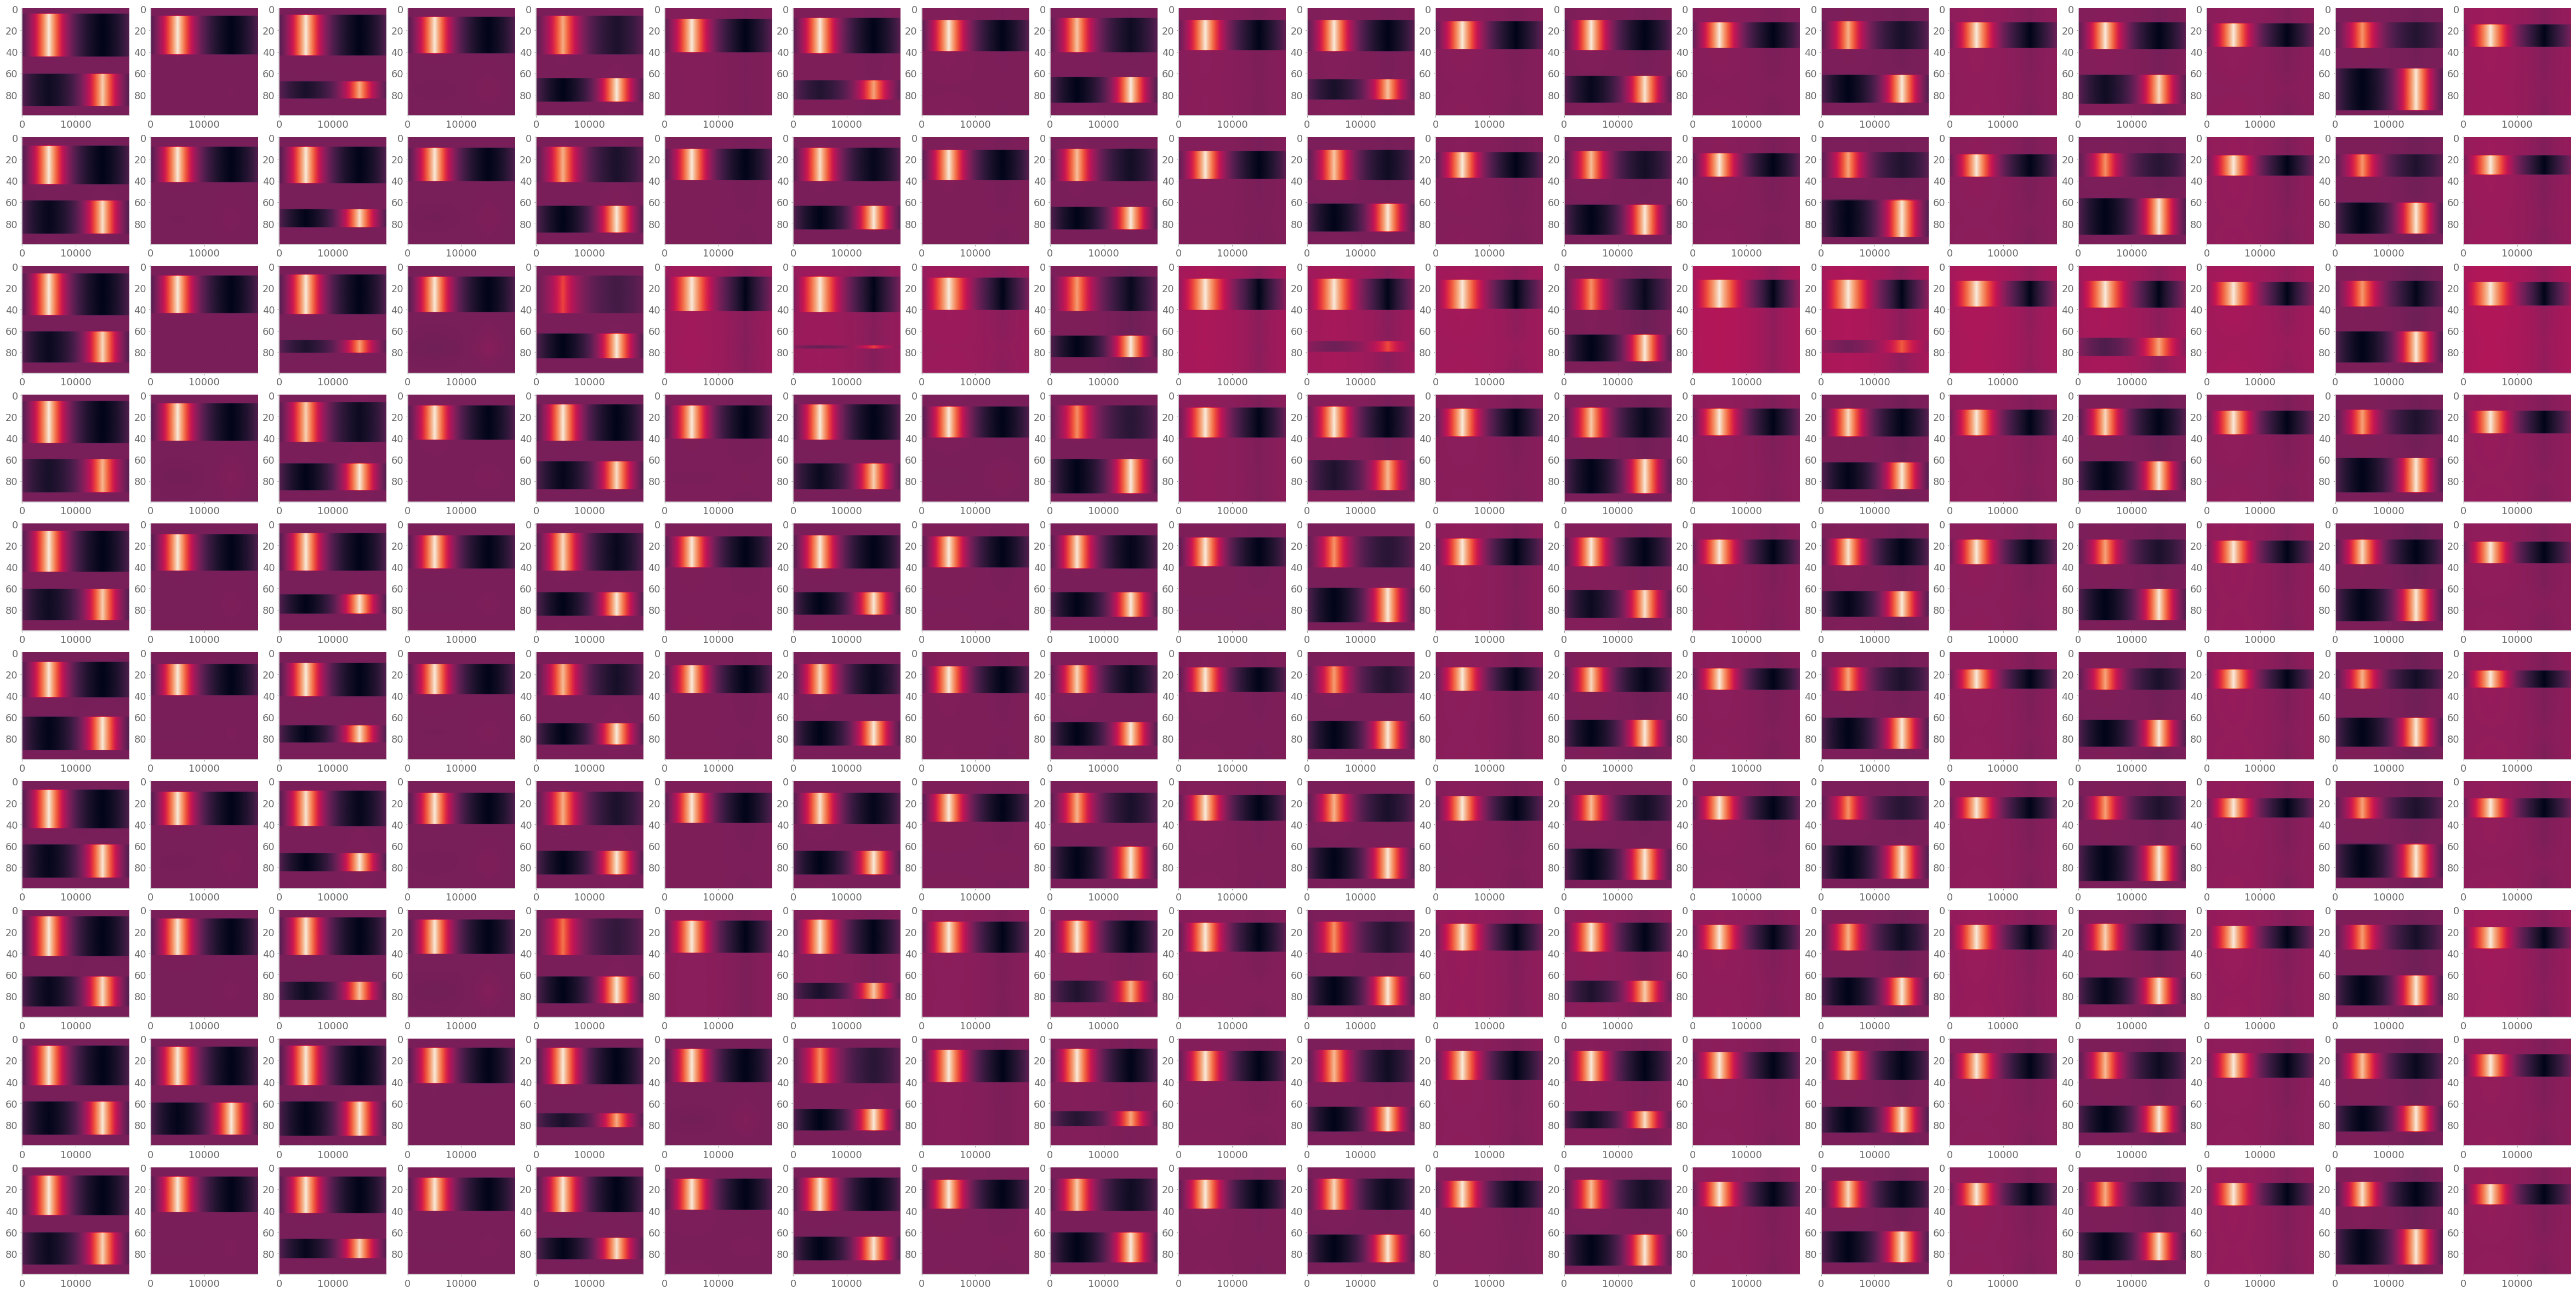

In [8]:
fig, ax = plt.subplots(num_trials, 2*num_recaches,  figsize=(6*num_recaches, 3*num_trials))
for trial in range(num_trials):
    for r in range(num_recaches):
        ax[trial, 2*r].imshow(post_cache_fantasy_reconstructions[trial,r], aspect="auto")
        ax[trial, 2*r+1].imshow(post_retrieval_fantasy_reconstructions[trial,r], aspect="auto")
plt.show()

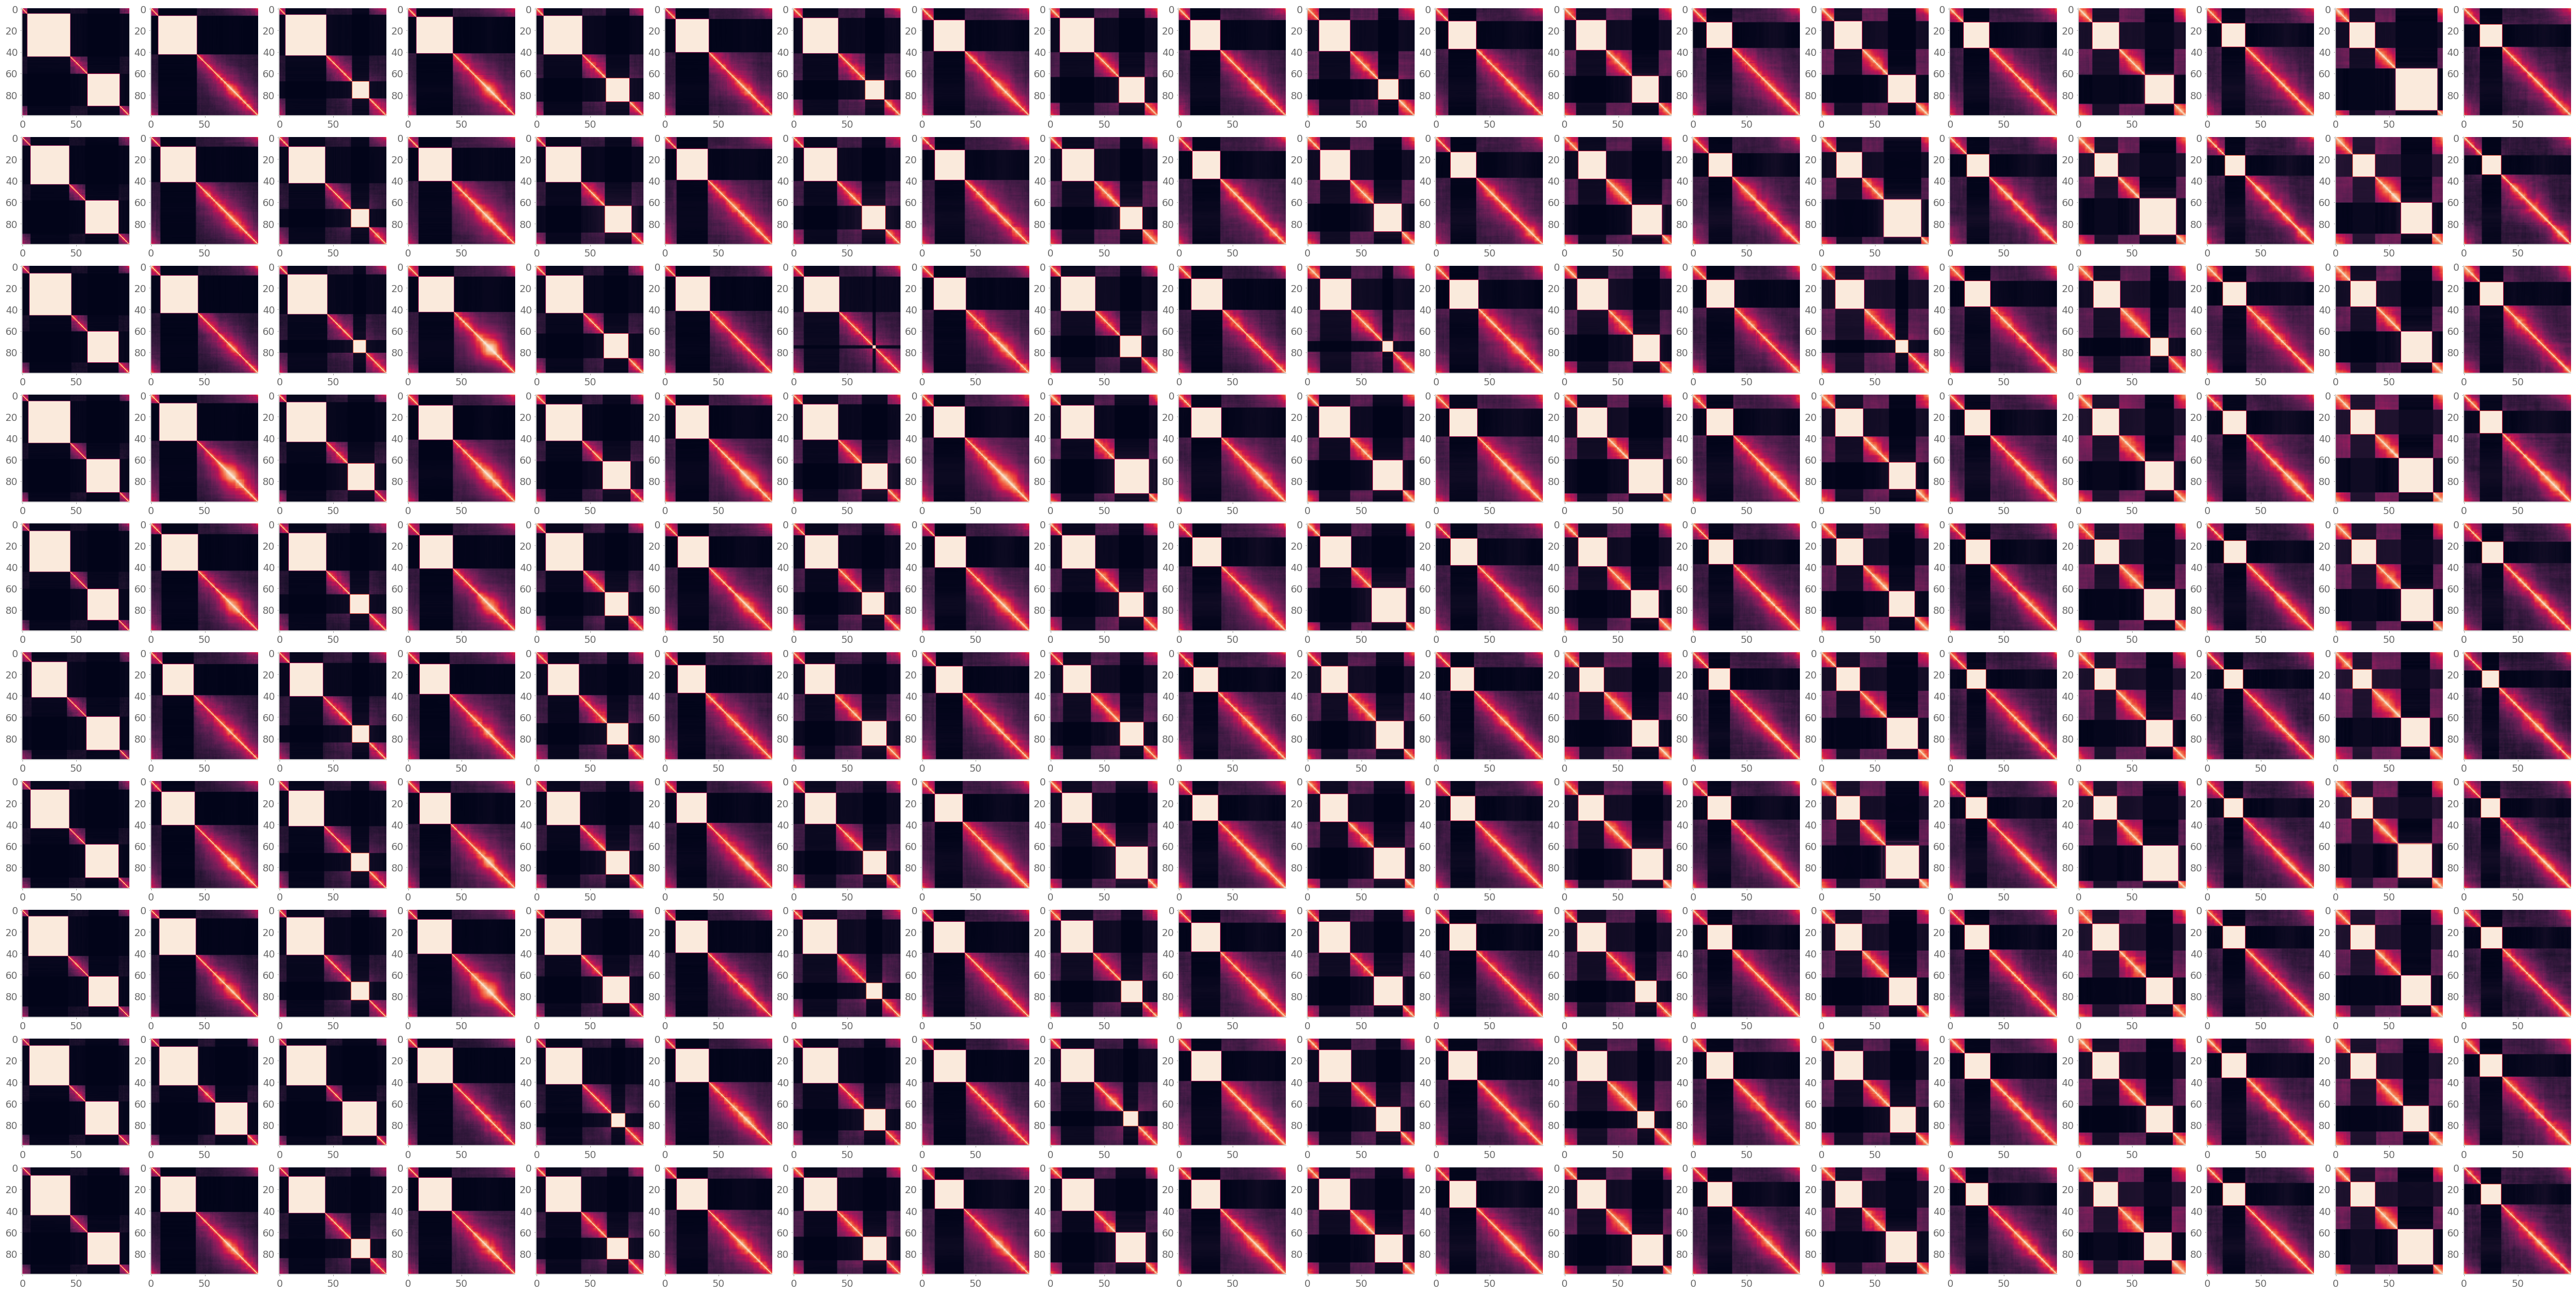

In [9]:
fig, ax = plt.subplots(num_trials, 2*num_recaches,  figsize=(6*num_recaches, 3*num_trials))
for trial in range(num_trials):
    for r in range(num_recaches):
        ax[trial, 2*r].imshow(np.corrcoef(post_cache_fantasy_acts[trial,r]), aspect="auto")
        ax[trial, 2*r+1].imshow(np.corrcoef(post_retrieval_fantasy_acts[trial,r]), aspect="auto")
plt.show()

10 good trials out of 10


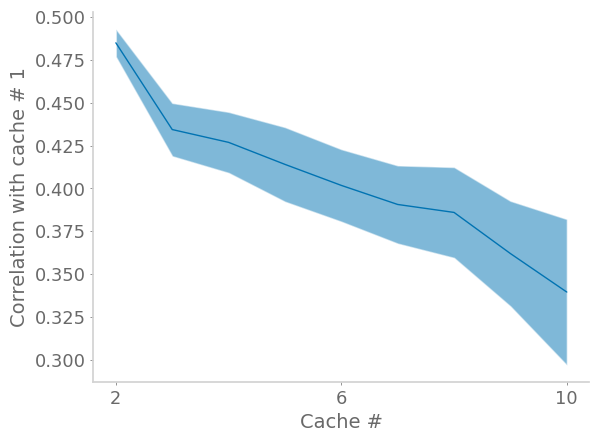

In [12]:
def cross_corr_from_pairwise(pairwise):
    results = []
    for i in range(1, len(pairwise)):
        results.append(np.nanmean(np.diagonal(pairwise, offset=i)))
    return np.array(results)

to_plot = np.array([cross_corr_from_pairwise(np.corrcoef(cache_acts[trial, :, forget_state])) for trial in range(num_trials)])
#to_plot = to_plot[~np.isnan(to_plot.mean(-1))]
print(len(to_plot), 'good trials out of', num_trials)

plt.plot(range(2, cache_acts.shape[1]+1), 
         np.nanmean(to_plot, 0))

plt.fill_between(range(2, cache_acts.shape[1]+1),
                np.nanmean(to_plot, 0)-np.nanstd(to_plot, 0)/np.sqrt(len(to_plot)),
                np.nanmean(to_plot, 0)+np.nanstd(to_plot, 0)/np.sqrt(len(to_plot)),
                alpha=0.5)

plt.xticks([2, 6, 10])
plt.xlabel("Cache #")
plt.ylabel("Correlation with cache # 1")
plt.show()